# Supervised Learning Project: Bank Marketing Dataset

In this notebook, I explore supervised learning algorithms including random forest, N-nearest neighbors, and Gradient Boosting to predict whether customers of a bank subscribe to thier term deposit program. This is a classification model, where the data was taken from Kaggle. (Link procided below)

https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset

Github Repo: https://github.com/Vedhik-Kodav/Bank-Marketing-Supervised-Learning.git

In [61]:
import math
import itertools
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


In [63]:
def plot_confusion_matrix(cm, classes,normalize,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# EDA

This data consistis of 11,162 records with 16 features and 1 target feature. I explore the data to and clean it by removing null columns, which were filled as unknown in this data. poutcome and contact had alarge percentage of null records, so those columns were removed entirely. I then removed any records with remaining null values. The resulting data frame consists of 10634 records and 14 features. I check correlations to see if I can do any feature engineering and try adding in age * retired and management * tertiary education. These engineered features did not have much impact on the models. I created dummy columns for all the categorical features and checked their feature importance. The only features that displayed significance for this model were the following: age, balance	duration, campaign, pdays, previous, housing_yes. These were the features used in the models.

In [32]:
bank_df=pd.read_csv('bank.csv')

In [33]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [34]:
bank_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [35]:
bank_df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [36]:
bank_df.replace('unknown', np.nan).isnull().sum()

age             0
job            70
marital         0
education     497
default         0
balance         0
housing         0
loan            0
contact      2346
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome     8326
deposit         0
dtype: int64

In [37]:
bank_df=bank_df.replace('unknown', np.nan)

In [38]:
#dropping poutcome and contact due to too many null values
bank_df.drop(labels=['poutcome', 'contact'], axis=1, inplace=True)
bank_df.dropna(inplace=True)
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10634 entries, 0 to 11161
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        10634 non-null  int64 
 1   job        10634 non-null  object
 2   marital    10634 non-null  object
 3   education  10634 non-null  object
 4   default    10634 non-null  object
 5   balance    10634 non-null  int64 
 6   housing    10634 non-null  object
 7   loan       10634 non-null  object
 8   day        10634 non-null  int64 
 9   month      10634 non-null  object
 10  duration   10634 non-null  int64 
 11  campaign   10634 non-null  int64 
 12  pdays      10634 non-null  int64 
 13  previous   10634 non-null  int64 
 14  deposit    10634 non-null  object
dtypes: int64(7), object(8)
memory usage: 1.3+ MB


In [39]:
#Getting dummy columns
bank_df=pd.concat([bank_df, pd.get_dummies(bank_df['default'],prefix='default', drop_first= True)], axis=1)
bank_df=pd.concat([bank_df, pd.get_dummies(bank_df['housing'],prefix='housing', drop_first= True)], axis=1)
bank_df=pd.concat([bank_df, pd.get_dummies(bank_df['loan'],prefix='loan', drop_first= True)], axis=1)
bank_df=pd.concat([bank_df, pd.get_dummies(bank_df['job'],prefix='job', drop_first= False)], axis=1)
bank_df=pd.concat([bank_df, pd.get_dummies(bank_df['marital'],prefix='marital', drop_first= False)], axis=1)
bank_df=pd.concat([bank_df, pd.get_dummies(bank_df['education'],prefix='education', drop_first= False)], axis=1)
bank_df=pd.concat([bank_df, pd.get_dummies(bank_df['deposit'],prefix='term deposit', drop_first= True)], axis=1)

In [40]:
bank_df

,age,job,marital,education,default,balance,housing,loan,day,month,...,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,term deposit_yes
0,59,admin.,married,secondary,no,2343,yes,no,5,may,...,0,0,0,0,1,0,0,1,0,1
1,56,admin.,married,secondary,no,45,no,no,5,may,...,0,0,0,0,1,0,0,1,0,1
2,41,technician,married,secondary,no,1270,yes,no,5,may,...,0,1,0,0,1,0,0,1,0,1
3,55,services,married,secondary,no,2476,yes,no,5,may,...,0,0,0,0,1,0,0,1,0,1
4,54,admin.,married,tertiary,no,184,no,no,5,may,...,0,0,0,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,20,apr,...,0,0,0,0,0,1,1,0,0,0
11158,39,services,married,secondary,no,733,no,no,16,jun,...,0,0,0,0,1,0,0,1,0,0
11159,32,technician,single,secondary,no,29,no,no,19,aug,...,0,1,0,0,0,1,0,1,0,0
11160,43,technician,married,secondary,no,0,no,yes,8,may,...,0,1,0,0,1,0,0,1,0,0


In [41]:
bank_df=bank_df.drop(labels=['default','marital', 'housing', 'day', 'month', 'education', 'marital', 'job', 'loan', 'deposit'], axis=1)

bank_df

,age,balance,duration,campaign,pdays,previous,default_yes,housing_yes,loan_yes,job_admin.,...,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,term deposit_yes
0,59,2343,1042,1,-1,0,0,1,0,1,...,0,0,0,0,1,0,0,1,0,1
1,56,45,1467,1,-1,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,1
2,41,1270,1389,1,-1,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,1
3,55,2476,579,1,-1,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,1
4,54,184,673,2,-1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,1,257,1,-1,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
11158,39,733,83,4,-1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
11159,32,29,156,2,-1,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
11160,43,0,9,2,172,5,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0


In [42]:
#Looking for any correlations between features or target
corr=bank_df.corr()
correlations=[]
for i in range(len(bank_df.columns)):
    cols=bank_df.columns
    col_corr=corr.loc[cols[i]].sort_values()
    cmin=col_corr[0]
    cmax=col_corr[25]
    corrs=[cols[i], col_corr.index[0], cmin, col_corr.index[25], cmax]
    correlations.append(corrs)


In [44]:
pd.DataFrame(correlations,columns=['Feature 1', 'Feature 2', 'Correlation 2', 'Feature 3', 'Correlation 3'] )


,Feature 1,Feature 2,Correlation 2,Feature 3,Correlation 3
0,age,marital_single,-0.462149,job_retired,0.557158
1,balance,loan_yes,-0.084233,age,0.113033
2,duration,campaign,-0.040578,term deposit_yes,0.454758
3,campaign,term deposit_yes,-0.127714,marital_married,0.042120
4,pdays,campaign,-0.105229,previous,0.508738
5,previous,campaign,-0.050445,pdays,0.508738
6,default_yes,balance,-0.060249,loan_yes,0.071703
7,housing_yes,term deposit_yes,-0.202066,job_blue-collar,0.183511
8,loan_yes,term deposit_yes,-0.112095,education_secondary,0.071986
9,job_admin.,job_management,-0.205382,education_secondary,0.241411


In [45]:
feature_1=pd.DataFrame(bank_df['age']*bank_df['job_retired'], columns=['age x retired'])
feature_2=pd.DataFrame(bank_df['job_management']*bank_df['education_tertiary'], columns=['management x tert. ed'])
bank_df=pd.concat([bank_df, feature_1, feature_2], axis=1)
bank_df

,age,balance,duration,campaign,pdays,previous,default_yes,housing_yes,loan_yes,job_admin.,...,job_unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,term deposit_yes,age x retired,management x tert. ed
0,59,2343,1042,1,-1,0,0,1,0,1,...,0,0,1,0,0,1,0,1,0,0
1,56,45,1467,1,-1,0,0,0,0,1,...,0,0,1,0,0,1,0,1,0,0
2,41,1270,1389,1,-1,0,0,1,0,0,...,0,0,1,0,0,1,0,1,0,0
3,55,2476,579,1,-1,0,0,1,0,0,...,0,0,1,0,0,1,0,1,0,0
4,54,184,673,2,-1,0,0,0,0,1,...,0,0,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,1,257,1,-1,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0
11158,39,733,83,4,-1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
11159,32,29,156,2,-1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
11160,43,0,9,2,172,5,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0


In [46]:
#Random Forrest Classification

rfc = ensemble.RandomForestClassifier(n_estimators=10, n_jobs=-1)
X = bank_df.drop(columns='term deposit_yes')
Y = bank_df['term deposit_yes']


print(f'{np.mean(cross_val_score(rfc, X, Y, cv=10))}\n')

0.7750680794177354



<AxesSubplot:title={'center':'Feature Importance'}>

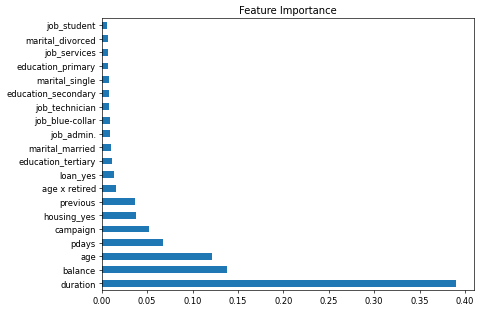

In [47]:
from matplotlib.pyplot import figure
rfc.fit(X, Y)
figure(figsize=(8, 6), dpi=60)

feat_importances = pd.Series(rfc.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh', title='Feature Importance')

In [48]:

cols=list(X.columns[8:29])
cols.append(X.columns[6])
cols.append('term deposit_yes')
bank_df.drop(columns=cols)

,age,balance,duration,campaign,pdays,previous,housing_yes
0,59,2343,1042,1,-1,0,1
1,56,45,1467,1,-1,0,0
2,41,1270,1389,1,-1,0,1
3,55,2476,579,1,-1,0,1
4,54,184,673,2,-1,0,0
...,...,...,...,...,...,...,...
11157,33,1,257,1,-1,0,1
11158,39,733,83,4,-1,0,0
11159,32,29,156,2,-1,0,0
11160,43,0,9,2,172,5,0


In [98]:
cols

['loan_yes',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'education_primary',
 'education_secondary',
 'education_tertiary',
 'age x retired',
 'management x tert. ed',
 'default_yes',
 'term deposit_yes']

# Models:

# Random Forest

In [49]:
#dropping columns of low importance and reperforming test
rfc = ensemble.RandomForestClassifier(n_estimators=10, n_jobs=-1)
X = bank_df.drop(columns=cols)
Y = bank_df['term deposit_yes']


print(f'{np.mean(cross_val_score(rfc, X, Y, cv=10))}\n')
     

0.774219031822265



In [99]:
X

,age,balance,duration,campaign,pdays,previous,housing_yes
0,59,2343,1042,1,-1,0,1
1,56,45,1467,1,-1,0,0
2,41,1270,1389,1,-1,0,1
3,55,2476,579,1,-1,0,1
4,54,184,673,2,-1,0,0
...,...,...,...,...,...,...,...
11157,33,1,257,1,-1,0,1
11158,39,733,83,4,-1,0,0
11159,32,29,156,2,-1,0,0
11160,43,0,9,2,172,5,0


<AxesSubplot:title={'center':'Feature Importance'}>

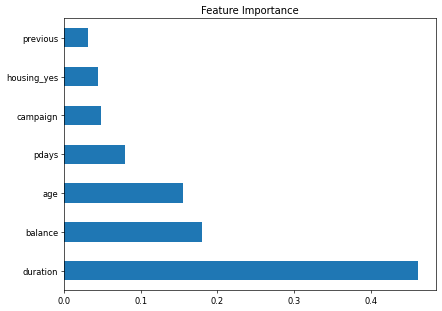

In [50]:
rfc.fit(X, Y)

figure(figsize=(8, 6), dpi=60)

feat_importances = pd.Series(rfc.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh', title='Feature Importance')
     

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 23)

In [55]:
scores=[]
for i in range(1,11):
    rfc = ensemble.RandomForestClassifier(n_estimators=i*10, n_jobs=-1)
    rfc.fit(X_train, y_train)
    scores.append([i,np.mean(cross_val_score(rfc, X_train, y_train, cv=10))])


In [56]:
#20 estimators looks like a good value to set, subsequent iterations have a negligible increase to cross_val_score
pd.DataFrame(scores)   

,0,1
0,1,0.787079
1,2,0.798495
2,3,0.799621
3,4,0.797114
4,5,0.799248
5,6,0.802254
6,7,0.799747
7,8,0.799370
8,9,0.801879
9,10,0.806143


In [57]:
#negligible difference when using entropy
rfc = ensemble.RandomForestClassifier(n_estimators=25, n_jobs=-1, criterion='entropy')
rfc.fit(X_train, y_train)
np.mean(cross_val_score(rfc, X_train, y_train, cv=10))

0.7963629273937667

In [58]:
#negligible difference when using gini, but optimal so far
rfc = ensemble.RandomForestClassifier(n_estimators=25, n_jobs=-1, criterion='gini')
rfc.fit(X_train, y_train)
np.mean(cross_val_score(rfc, X_train, y_train, cv=10))

0.8002510982600792

In [62]:
y_pred = rfc.predict(X_test)
accuracy_score(y_pred, list(y_test))

0.7972922151184656

Confusion matrix, without normalization


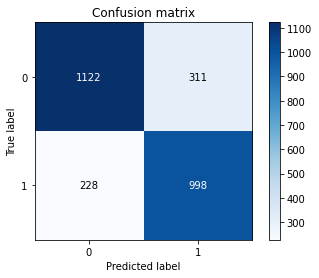

In [65]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,[0,1],False)

Normalized confusion matrix


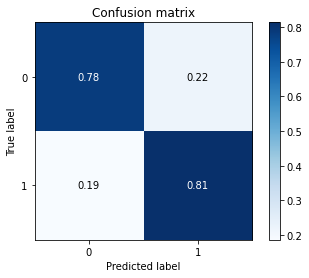

In [67]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,[0,1],True)

In [69]:
RF_accuracy=rfc.score(X_test, y_test)
RF_precision=precision_score(y_test,y_pred)
RF_recall= recall_score(y_test,y_pred)

In [100]:
print(RF_accuracy,RF_precision,RF_recall)

0.7972922151184656 0.7624140565317036 0.8140293637846656


This model has an accuracy of .80, precision of .76, and and recall of .81. Hypertuning was performed on the n_estimators to improve these scores.

# K-nearest Neighbors

In [70]:
#K-nearest neighbors
scores=[]
for i in range(1,20):
    neighbors = KNeighborsClassifier(n_neighbors=i)
    neighbors.fit(X_train,y_train)
    scores.append([i,np.mean(cross_val_score(neighbors, X_train, y_train, cv=10))])

In [71]:
#9 neighbors provides the best score and minimizes overfitting
pd.DataFrame(scores)

,0,1
0,1,0.699811
1,2,0.693665
2,3,0.733164
3,4,0.731033
4,5,0.744702
5,6,0.741566
6,7,0.748714
7,8,0.747208
8,9,0.750845
9,10,0.751093


In [73]:
#weighted by distance doesnt affect it much
neighbors = KNeighborsClassifier(n_neighbors=9, weights='distance')
neighbors.fit(X_train,y_train)
np.mean(cross_val_score(neighbors, X_train, y_train, cv=10))

0.7505946484781589

In [75]:
#negligible differences in algorithm

neighbors = KNeighborsClassifier(n_neighbors=9, weights='uniform', algorithm='ball_tree')
neighbors.fit(X_train,y_train)
A=np.mean(cross_val_score(neighbors, X_train, y_train, cv=10))

neighbors = KNeighborsClassifier(n_neighbors=9, weights='uniform', algorithm='kd_tree')
neighbors.fit(X_train,y_train)
B=np.mean(cross_val_score(neighbors, X_train, y_train, cv=10))

neighbors = KNeighborsClassifier(n_neighbors=9, weights='uniform', algorithm='brute')
neighbors.fit(X_train,y_train)
C=np.mean(cross_val_score(neighbors, X_train, y_train, cv=10))

neighbors = KNeighborsClassifier(n_neighbors=9, weights='uniform', algorithm='auto')
neighbors.fit(X_train,y_train)
D=np.mean(cross_val_score(neighbors, X_train, y_train, cv=10))

print(A,B,C, D)

0.750844960582133 0.750844960582133 0.750970273865341 0.750844960582133


In [76]:
neighbors = KNeighborsClassifier(n_neighbors=9, weights='uniform', algorithm='auto')
neighbors.fit(X_train, y_train)
np.mean(cross_val_score(neighbors, X_train, y_train, cv=10))

0.750844960582133

In [78]:
y_pred=neighbors.predict(X_test)
accuracy_score(y_pred, list(y_test))

0.7525385483264385

Confusion matrix, without normalization


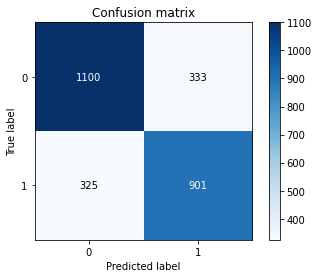

In [80]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,[0,1],False)

Normalized confusion matrix


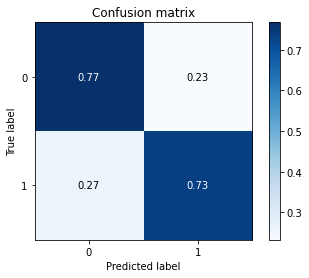

In [82]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,[0,1],True)

In [84]:
KNN_accuracy=neighbors.score(X_test, y_test)
KNN_precision=precision_score(y_test,y_pred)
KNN_recall= recall_score(y_test,y_pred)

In [101]:
print(KNN_accuracy, KNN_precision, KNN_recall)

0.7525385483264385 0.7301458670988655 0.734910277324633


This model has an accuracy of .75, precision of .73, and and recall of .73. Hypertuning was performed on the n_nearest neighbors and algorthim parameters to improve these scores.

# Gradient Boosting

In [85]:

#Gradient boosting classifier
scores=[]
for i in range(10,21):

    params = {'n_estimators': i*10,
            'max_depth': 3,
            'loss': 'deviance'}


    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    scores.append([i,np.mean(cross_val_score(clf, X_train, y_train, cv=10))])

In [86]:
pd.DataFrame(scores)

,0,1
0,10,0.809027
1,11,0.809279
2,12,0.809404
3,13,0.808778
4,14,0.808903
5,15,0.808402
6,16,0.809279
7,17,0.808026
8,18,0.808151
9,19,0.807775


In [87]:
scores=[]
for i in range(2,6):

    params = {'n_estimators': 100,
            'max_depth': i,
            'loss': 'deviance'}


    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    scores.append([i,np.mean(cross_val_score(clf, X_train, y_train, cv=10))])
     

In [88]:
pd.DataFrame(scores)

,0,1
0,2,0.805392
1,3,0.808777
2,4,0.809027
3,5,0.808402


In [89]:
params = {'n_estimators': 100,
          'max_depth': 4,
          'loss': 'exponential'}


clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)
np.mean(cross_val_score(clf, X_train, y_train, cv=10))

0.8117874674138295

In [90]:
scores=[]
for i in range(1,11):

    params = {'n_estimators': 100,
            'max_depth': 4,
            'loss': 'deviance',
            'learning_rate': i*.1}


    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    scores.append([i,np.mean(cross_val_score(clf, X_train, y_train, cv=10))])

In [91]:
pd.DataFrame(scores)

,0,1
0,1,0.809654
1,2,0.806269
2,3,0.801503
3,4,0.794480
4,5,0.791096
5,6,0.785703
6,7,0.778682
7,8,0.779685
8,9,0.773412
9,10,0.767901


In [92]:
params = {'n_estimators': 100,
          'max_depth': 4,
          'loss': 'deviance',
          'learning_rate': .1}


clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)
np.mean(cross_val_score(clf, X_train, y_train, cv=10))

0.8091522721483759

In [93]:
GB_accuracy=clf.score(X_test, y_test)
y_preds = clf.predict(X_test)
GB_precision=precision_score(y_test,y_preds)
GB_recall= recall_score(y_test,y_preds)

Confusion matrix, without normalization


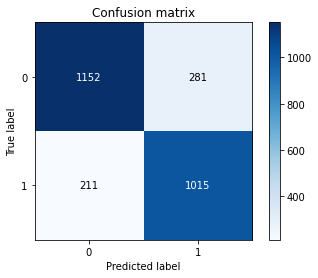

In [94]:
cm = confusion_matrix(y_test, y_preds)
plot_confusion_matrix(cm,[0,1],False)

Normalized confusion matrix


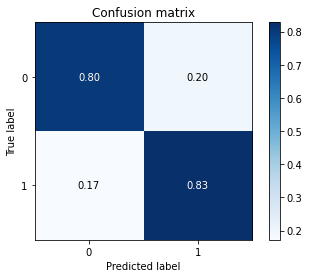

In [95]:
cm = confusion_matrix(y_test, y_preds)
plot_confusion_matrix(cm,[0,1],True)

In [102]:
print(GB_accuracy,GB_precision,GB_recall)

0.8149680330951485 0.783179012345679 0.8278955954323002


This model has an accuracy of .81, precision of .78, and and recall of .83. Hypertuning was performed on the n_estimators, max_depth, loss, and learning rate parameters to improve these scores

# Summary

In [96]:
data=[['Accuracy', RF_accuracy, KNN_accuracy, GB_accuracy], ['Precision', RF_precision, KNN_precision, GB_precision], ['Recall', RF_recall, KNN_recall, GB_recall]]
columns=['', 'Random Forest', 'K-Nearest Neighbor', 'Gradient Boosting']
summary=pd.DataFrame(data=data, columns=columns)

In [97]:
summary

,,Random Forest,K-Nearest Neighbor,Gradient Boosting
0,Accuracy,0.797292,0.752539,0.814968
1,Precision,0.762414,0.730146,0.783179
2,Recall,0.814029,0.734910,0.827896


Gradient Boosting is the most optimal algorithm followed closely by Random Forest. K-nearest neighbors is not as suitable for this dataset. I used Accuracy, Precision, and Recall as my metrics. Further feature engineering or additional banking data may help imporve this model. 